# Exploratory Data Analysis and Modeling

## Problem Statement
When is the best time to release a new song/album on Spotify?
As a major label artist, planning and preparing a successful release goes further than finding a great single or recording a critically acclaimed album. A strategic rollout is essential to standing out and cutting through noise in this highly competitive industry. The target of this project is to pinpoint an effective time to release new music.

In order to achieve this, I decided to gather data from the largest music streaming service, Spotify, along with chart data from the industry publication Billboard to analyze the songs that see the most success while on the best selling/most listened to charts.

This notebook goes through the EDA steps I took to analyze the data as well as the model used to predict when a song was released on Spotify. I chose to use a Random Forest Classifier to determine the season (also referred to as a quarter) based on the interpretability of feature importance and the tendency of the model to reduce overfitting, which I am anticipating to be an issue based on data quality due to previous setbacks (lack of access to Nielson Soundscan data). 

In [134]:
# Importing packages. Using both a randomized search and gridsearch since I am unsure what parameters to tune.

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
%matplotlib inline

from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [135]:
df = pd.read_csv('data/song_data.csv')
df.head()

,track_name,artist_name,released_on,streams,bb_hot_100_peak,sp_top_200_peak,genres,artist_popularity,artist_followers,month_released
0,...Ready For It?,Taylor Swift,2017-11-10,56087780,4,6,dance pop pop post-teen pop,92,19739479,11
1,1-800-273-8255,Logic,2017-05-05,316028795,3,1,conscious hip hop dmv rap hip hop pop rap rap,90,3630301,5
2,1.5,21 Savage,2018-12-21,8834772,86,52,atl hip hop rap trap music,90,6057541,12
3,10 Freaky Girls (with 21 Savage),Metro Boomin,2018-11-06,68506670,42,11,hip hop pop pop rap rap southern hip hop trap ...,85,1259993,11
4,1400 / 999 Freestyle,Trippie Redd,2018-11-09,45818520,55,23,rap trap music,86,2947101,11


In [136]:
# Ensuring NaNs have been dropped and resetting index. 

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [137]:
# Based on complexity, I decided to predict season/quarter instead of month of release. 12 classes may be challenging

season = []
for i in range(0, len(df)):
    if df['month_released'][i] < 4:
        season.append(1)
    elif (df['month_released'][i] >= 4) & (df['month_released'][i] < 7):
        season.append(2)
    elif (df['month_released'][i] >= 7) & (df['month_released'][i] < 10):
        season.append(3)
    else:
        season.append(4)

In [138]:
df['season_released'] = season

<br>
I am using count vectorizer to transform qualitative 'genre' column for modeling. I am hypothesizing that genre may have and impact on release time frame and song performance. After collecting the top 10 features (words or 2 word phrases), I will one hot encode the genre categories for use in EDA and the model
<br>
<br>

In [139]:
cvec = CountVectorizer(max_features=10, ngram_range=(1,2))
cvec.fit(df['genres'])
genre_transform = cvec.transform(df['genres'])

genre = pd.DataFrame(genre_transform.toarray(), columns=cvec.get_feature_names())
combined = pd.concat([df, genre], axis=1)

In [140]:
one_hot_genre = []
for i in range(0, len(combined)):
    if (combined['pop'][i] >= 1) & (combined['hip'][i] == 0) & (combined['rap'][i] == 0):
        one_hot_genre.append(1)
    elif (combined['pop'][i] == 0) & (combined['hip'][i] >= 1) & (combined['rap'][i] >= 1):
        one_hot_genre.append(2)
    elif (combined['pop'][i] == 0) & (combined['hip'][i] == 0) & (combined['rap'][i] == 0):
        one_hot_genre.append(3)
    else:
        one_hot_genre.append(0)
        
combined['genre_cat'] = one_hot_genre

# EDA

Unfortunately, there is not as much linearity in my data, which may become a problem. The below heatmaps show a lack of significant correlation between my prediction value and a marker of success in the industry, Billboard Hot 100 peak position.
<br>
<br>

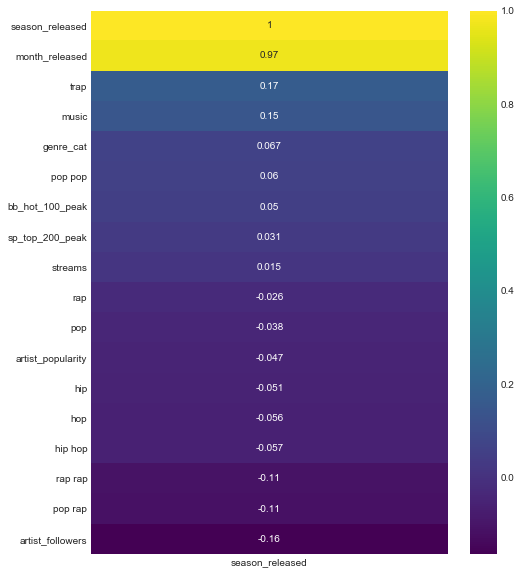

In [8]:
corr = combined.corr()

plt.figure(figsize=(8, 10))

mask = np.zeros_like(combined.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(combined.corr()[['season_released']].sort_values('season_released', ascending=False),
            annot=True, cmap='viridis');

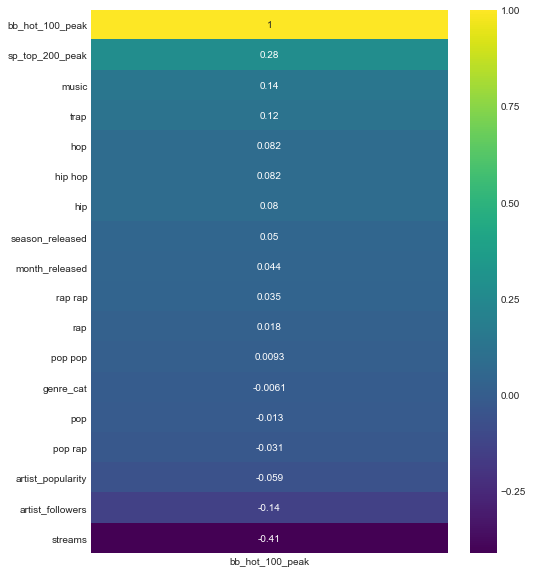

In [9]:
corr = combined.corr()

plt.figure(figsize=(8, 10))

mask = np.zeros_like(combined.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(combined.corr()[['bb_hot_100_peak']].sort_values('bb_hot_100_peak', ascending=False),
            annot=True, cmap='viridis');

<br>
While the lack of correlation is troubling, EDA showed that songs released in Q2 (Late Spring) and Q4 (Winter/Holiday Season) spend time on the Billboard and Spotify Charts. A promising sign for advising when to release a song or album.
<br>
<br>

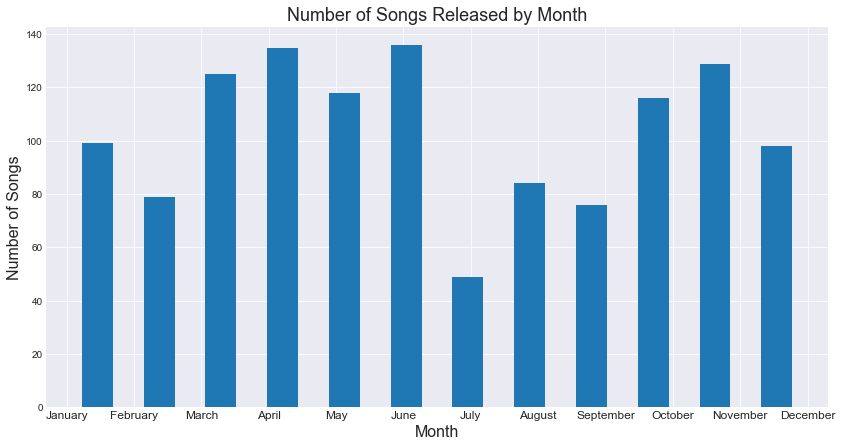

In [141]:
plt.figure(figsize=(14,7))

plt.hist(combined['month_released'], rwidth = .5, bins=12)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
            'October', 'November', 'December'], size=12)
plt.title('Number of Songs Released by Month', size=18)
plt.xlabel('Month', size=16)

plt.ylabel('Number of Songs', size=16);

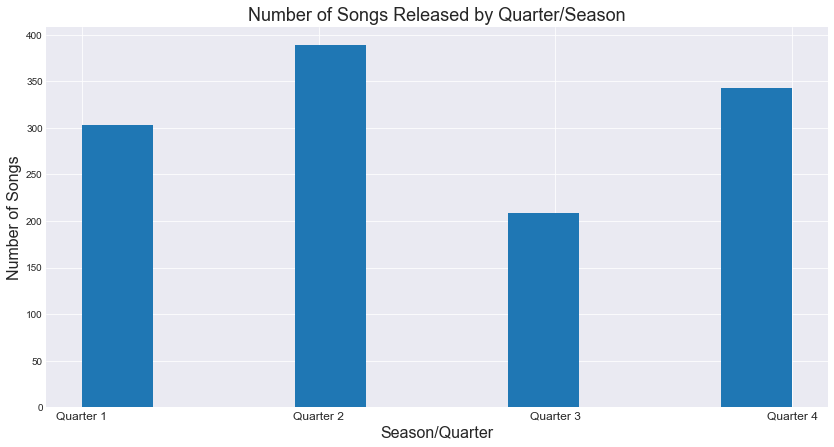

In [142]:
plt.figure(figsize=(14,7))
plt.hist(combined['season_released'], align='mid')
plt.xticks([1, 2, 3, 4], ['Quarter 1', 'Quarter 2', 'Quarter 3', 'Quarter 4'], size=12)
plt.title('Number of Songs Released by Quarter/Season', size=18)
plt.xlabel('Season/Quarter', size=16)
plt.ylabel('Number of Songs', size=16);

<br>
Songs released in April and June have substantially more plays than those any other month of the year.
<br>
<br>

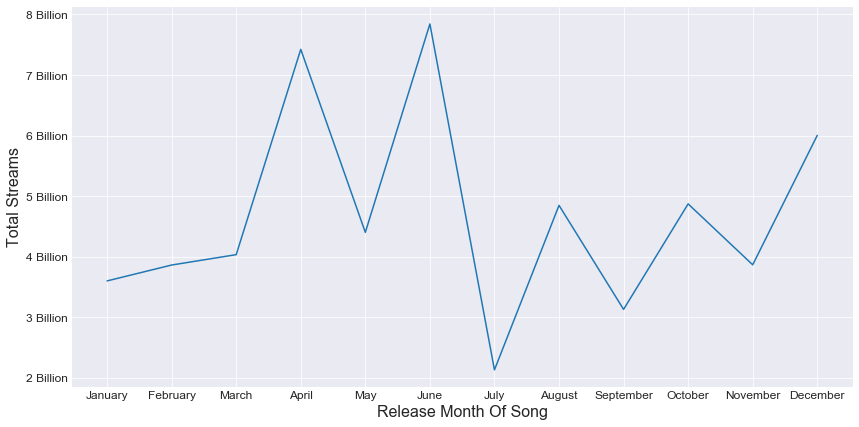

In [148]:
plt.figure(figsize=(14,7))
plt.plot(combined['streams'].groupby(combined['month_released']).sum())
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
           ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
            'October', 'November', 'December'], size=12) 
plt.yticks([2_000_000_000, 3_000_000_000, 4_000_000_000, 5_000_000_000, 6_000_000_000, 7_000_000_000, 8_000_000_000],
           ['2 Billion', '3 Billion', '4 Billion', '5 Billion', '6 Billion', '7 Billion', '8 Billion'], size=12)
plt.xlabel('Release Month Of Song', size=16)
plt.ylabel('Total Streams', size=16);

In [150]:
sp_100_scaled = combined[combined['sp_top_200_peak'] <= 100]

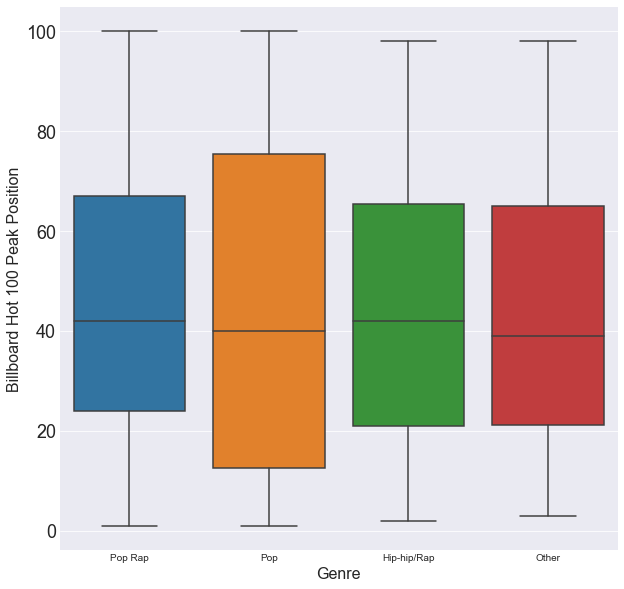

In [151]:
plt.figure(figsize=(10,10))
sns.boxplot(x='genre_cat', y='bb_hot_100_peak', data=sp_100_scaled)
#plt.xticks([0, 1, 2, 3], ['Pop Rap', 'Pop', 'Hip-hip/Rap', 'Other'], size=12)
plt.yticks([0, 20, 40, 60, 80, 100], size=18)
plt.xticks([0, 1, 2, 3], ['Pop Rap', 'Pop', 'Hip-hip/Rap', 'Other'])
plt.xlabel('Genre', size=16)
plt.ylabel('Billboard Hot 100 Peak Position', size=16);

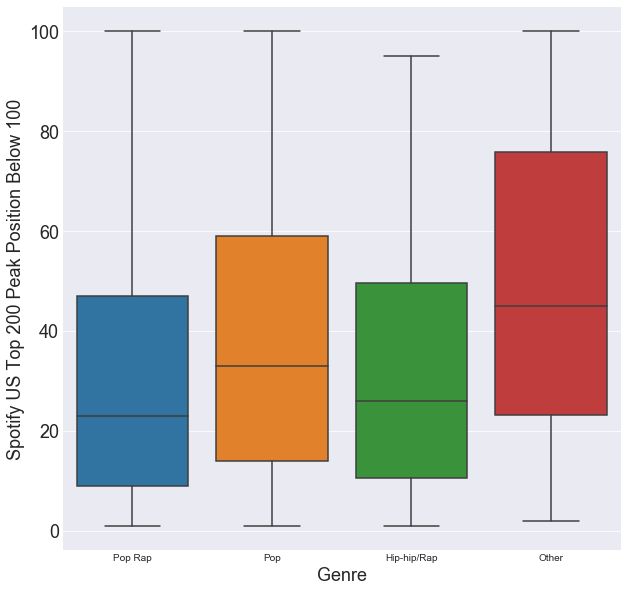

In [155]:
plt.figure(figsize=(10,10))
sns.boxplot(x='genre_cat', y='sp_top_200_peak', data=sp_100_scaled)
plt.yticks([0, 20, 40, 60, 80, 100], size=18)
plt.xticks([0, 1, 2, 3], ['Pop Rap', 'Pop', 'Hip-hip/Rap', 'Other'])
plt.xlabel('Genre', size=18)
plt.ylabel('Spotify US Top 200 Peak Position Below 100', size =18);

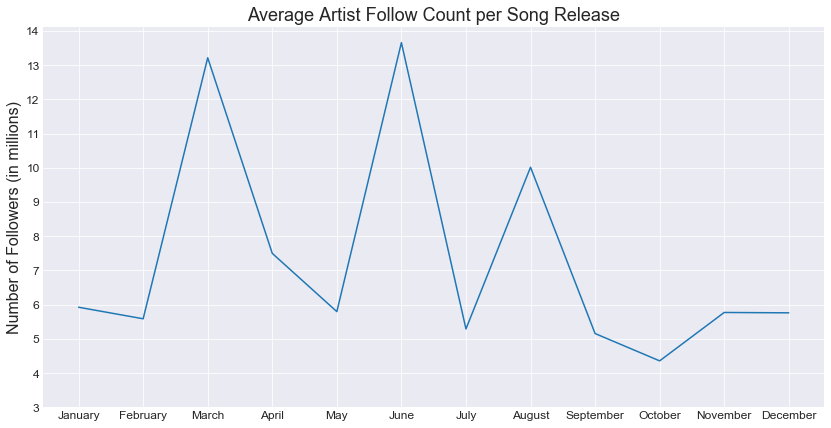

In [159]:
plt.figure(figsize=(14,7))

plt.plot(combined['artist_followers'].groupby(combined['month_released']).mean())
plt.title('Average Artist Follow Count per Song Release', size=18)
plt.ylabel('Number of Followers (in millions)', size=16)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
           ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
            'October', 'November', 'December'], size=12) 
plt.yticks([3_000_000, 4_000_000, 5_000_000, 6_000_000, 7_000_000, 8_000_000, 9_000_000, 10_000_000,
            11_000_000, 12_000_000, 13_000_000, 14_000_000], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], size=12);

<br>
Based on my hypothesis of genre factoring into release date, I wanted to explore the most popular artists based on genre, measured by their popularity measure on Spotify. Artists with roots in the hip-hop and rap genres have the highest popularity currently, and those with crossover into pop are the most popular based on this data.
<br>
<br>

In [15]:
combined[combined['genre_cat'] == 1].describe()

,streams,bb_hot_100_peak,sp_top_200_peak,artist_popularity,artist_followers,month_released,season_released,hip,hip hop,hop,music,pop,pop pop,pop rap,rap,rap rap,trap,genre_cat
count,3.990000e+02,399.000000,399.000000,399.000000,3.990000e+02,399.000000,399.000000,399.0,399.0,399.000000,399.000000,399.000000,399.000000,399.0,399.0,399.0,399.000000,399.0
mean,4.254882e+07,47.779449,67.042607,84.546366,8.170387e+06,6.177945,2.441103,0.0,0.0,0.002506,0.002506,2.220551,0.343358,0.0,0.0,0.0,0.015038,1.0
std,5.980833e+07,30.567274,55.307279,8.711872,8.914286e+06,3.474373,1.150012,0.0,0.0,0.050063,0.050063,1.182570,0.475426,0.0,0.0,0.0,0.121855,0.0
min,1.024988e+06,1.000000,1.000000,54.000000,2.688000e+03,1.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,1.0
25%,5.282139e+06,21.000000,19.500000,80.000000,1.723295e+06,3.000000,1.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.000000,1.0
50%,1.755603e+07,44.000000,52.000000,85.000000,6.112029e+06,6.000000,2.000000,0.0,0.0,0.000000,0.000000,2.000000,0.000000,0.0,0.0,0.0,0.000000,1.0
75%,5.192699e+07,75.000000,103.000000,90.000000,1.182745e+07,10.000000,4.000000,0.0,0.0,0.000000,0.000000,3.000000,1.000000,0.0,0.0,0.0,0.000000,1.0
max,3.642045e+08,100.000000,196.000000,100.000000,4.387636e+07,12.000000,4.000000,0.0,0.0,1.000000,1.000000,5.000000,1.000000,0.0,0.0,0.0,1.000000,1.0


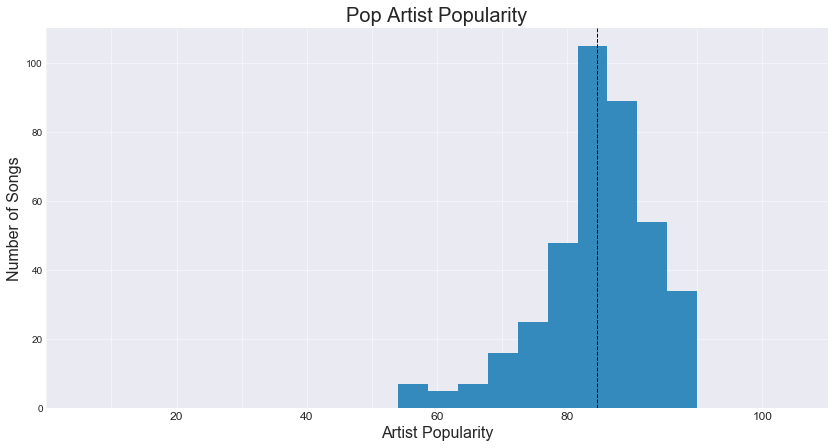

In [723]:
plt.figure(figsize=(14,7))
plt.hist(combined[combined['genre_cat'] == 1]['artist_popularity'], align='mid')
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 110, 120], ['', '', 20, '', 40, '', 60, '', 80, '', 100, '', ''],
           size=12)
plt.axvline(combined[combined['genre_cat'] == 1]['artist_popularity'].mean(), 
            color='k', linestyle='dashed', linewidth=1)
plt.title('Pop Artist Popularity', size=20)
plt.xlabel('Artist Popularity', size=16)
plt.ylabel('Number of Songs', size=16);

In [16]:
combined[combined['genre_cat'] == 2].describe()

,streams,bb_hot_100_peak,sp_top_200_peak,artist_popularity,artist_followers,month_released,season_released,hip,hip hop,hop,music,pop,pop pop,pop rap,rap,rap rap,trap,genre_cat
count,1.140000e+02,114.000000,114.000000,114.00000,1.140000e+02,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.0,114.0,114.0,114.000000,114.000000,114.000000,114.0
mean,5.624912e+07,48.684211,58.298246,87.95614,7.974553e+06,8.166667,3.052632,1.175439,1.175439,1.175439,0.561404,0.0,0.0,0.0,1.026316,0.026316,0.798246,2.0
std,8.134215e+07,28.760320,54.160680,6.65375,7.885015e+06,3.293643,1.143215,0.382021,0.382021,0.382021,0.498406,0.0,0.0,0.0,0.160779,0.160779,0.789083,0.0
min,1.219493e+06,2.000000,1.000000,59.00000,1.860600e+05,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,2.0
25%,4.051890e+06,24.000000,15.250000,85.00000,2.073903e+06,5.500000,2.250000,1.000000,1.000000,1.000000,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000,2.0
50%,1.720759e+07,45.000000,36.000000,88.00000,4.655966e+06,9.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.000000,1.000000,2.0
75%,6.394013e+07,73.500000,93.750000,94.00000,1.274861e+07,11.000000,4.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,0.000000,1.000000,2.0
max,3.458775e+08,99.000000,192.000000,94.00000,2.656235e+07,12.000000,4.000000,2.000000,2.000000,2.000000,1.000000,0.0,0.0,0.0,2.000000,1.000000,2.000000,2.0


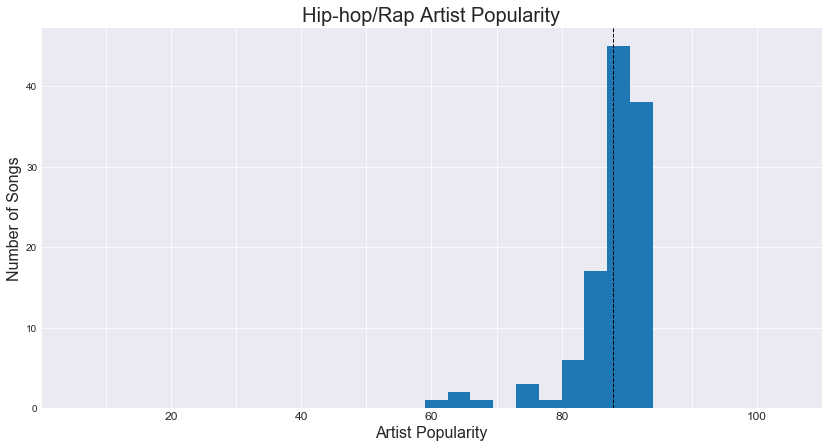

In [17]:
plt.figure(figsize=(14, 7))
plt.hist(combined[combined['genre_cat'] == 2]['artist_popularity'])
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 110, 120], ['', '', 20, '', 40, '', 60, '', 80, '', 100, '', ''],
            size=12)
plt.axvline(combined[combined['genre_cat'] == 2]['artist_popularity'].mean(), 
            color='k', linestyle='dashed', linewidth=1)
plt.title('Hip-hop/Rap Artist Popularity', size=20)
plt.xlabel('Artist Popularity', size=16)
plt.ylabel('Number of Songs', size=16);

In [18]:
combined[combined['genre_cat'] == 3].describe()

,streams,bb_hot_100_peak,sp_top_200_peak,artist_popularity,artist_followers,month_released,season_released,hip,hip hop,hop,music,pop,pop pop,pop rap,rap,rap rap,trap,genre_cat
count,1.270000e+02,127.000000,127.000000,127.000000,1.270000e+02,127.000000,127.000000,127.0,127.0,127.0,127.000000,127.0,127.0,127.0,127.0,127.0,127.000000,127.0
mean,3.441801e+07,45.566929,102.086614,76.881890,3.759192e+06,6.322835,2.409449,0.0,0.0,0.0,0.181102,0.0,0.0,0.0,0.0,0.0,0.244094,3.0
std,5.025488e+07,24.676507,63.533521,13.385976,5.549989e+06,3.410725,1.056757,0.0,0.0,0.0,0.386628,0.0,0.0,0.0,0.0,0.0,0.431250,0.0
min,1.029544e+06,1.000000,2.000000,11.000000,1.710000e+02,1.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3.0
25%,2.233832e+06,28.000000,45.000000,72.500000,7.649680e+05,4.000000,2.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3.0
50%,1.371186e+07,40.000000,99.000000,78.000000,1.481548e+06,6.000000,2.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3.0
75%,4.246336e+07,60.500000,160.500000,86.000000,2.673090e+06,9.000000,3.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3.0
max,2.597745e+08,98.000000,200.000000,95.000000,1.857678e+07,12.000000,4.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,3.0


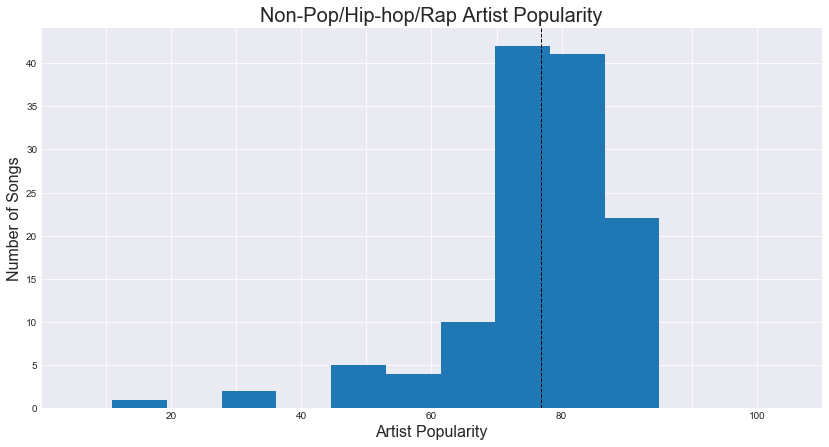

In [19]:
plt.figure(figsize=(14, 7))
plt.hist(combined[combined['genre_cat'] == 3]['artist_popularity'])
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 110, 120], ['', '', 20, '', 40, '', 60, '', 80, '', 100, '', ''])
plt.axvline(combined[combined['genre_cat'] == 3]['artist_popularity'].mean(), 
            color='k', linestyle='dashed', linewidth=1)
plt.title('Non-Pop/Hip-hop/Rap Artist Popularity', size=20)
plt.xlabel('Artist Popularity', size=16)
plt.ylabel('Number of Songs', size=16);

In [20]:
combined[combined['genre_cat'] == 0].describe()

,streams,bb_hot_100_peak,sp_top_200_peak,artist_popularity,artist_followers,month_released,season_released,hip,hip hop,hop,music,pop,pop pop,pop rap,rap,rap rap,trap,genre_cat
count,6.040000e+02,604.000000,604.000000,604.000000,6.040000e+02,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.000000,604.0
mean,4.675791e+07,47.201987,52.269868,86.644040,8.100478e+06,6.346026,2.403974,1.450331,1.418874,1.418874,0.503311,1.557947,0.504967,0.842715,1.918874,0.711921,0.539735,0.0
std,7.601443e+07,27.428223,51.387950,7.108548,9.712678e+06,3.424301,1.111847,1.125249,1.151122,1.151122,0.500403,1.008235,0.568646,0.403258,0.765145,0.453244,0.558437,0.0
min,9.857860e+05,1.000000,1.000000,64.000000,3.426400e+04,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,5.495411e+06,27.000000,12.000000,84.000000,2.533874e+06,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0
50%,1.694145e+07,44.000000,33.000000,87.000000,4.485183e+06,6.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.0
75%,4.972834e+07,70.000000,79.000000,91.000000,8.747513e+06,9.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.0
max,5.072172e+08,100.000000,200.000000,97.000000,3.657218e+07,12.000000,4.000000,4.000000,4.000000,4.000000,1.000000,6.000000,2.000000,2.000000,4.000000,1.000000,2.000000,0.0


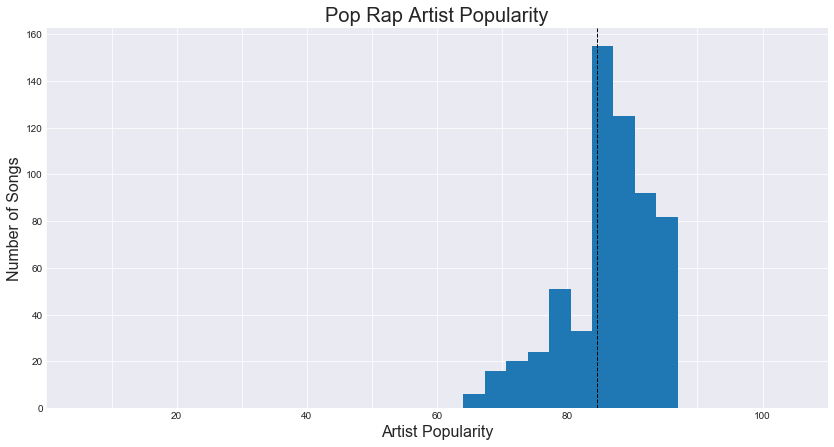

In [21]:
plt.figure(figsize=(14,7))
plt.hist(combined[combined['genre_cat'] == 0]['artist_popularity'])
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 110, 120], ['', '', 20, '', 40, '', 60, '', 80, '', 100, '', ''])
plt.axvline(combined[combined['genre_cat'] == 1]['artist_popularity'].mean(), 
            color='k', linestyle='dashed', linewidth=1)
plt.title('Pop Rap Artist Popularity', size=20)
plt.xlabel('Artist Popularity', size=16)
plt.ylabel('Number of Songs', size=16);

# Modeling

The random forest model was trained on 70% of the above data and the predicted value, release season, was stratified in the train and test columns.
<br>
Baseline accuracy for the majority class model is 30%.

The data was then normalized prior to training the model as the scales on different features are significantly different.

In [22]:
combined.columns

Index(['track_name', 'artist_name', 'released_on', 'streams',
       'bb_hot_100_peak', 'sp_top_200_peak', 'genres', 'artist_popularity',
       'artist_followers', 'month_released', 'season_released', 'hip',
       'hip hop', 'hop', 'music', 'pop', 'pop pop', 'pop rap', 'rap',
       'rap rap', 'trap', 'genre_cat'],
      dtype='object')

In [23]:
features = ['streams', 'bb_hot_100_peak', 'sp_top_200_peak', 'artist_popularity', 'artist_followers', 'genre_cat']
X= combined[features]
y = combined['season_released']

In [24]:
y.value_counts(normalize=True)

2    0.312701
4    0.275723
1    0.243569
3    0.168006
Name: season_released, dtype: float64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify = y)

In [26]:
ss = StandardScaler()

ss.fit(X_train)

Xs_train = ss.transform(X_train)
Xs_test = ss.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


Based on the model and limitations in the data, I decided to run a randomized cross validation to pinpoint some potential hyperparamters in the model.

In [27]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://stackoverflow.com/questions/38555650/try-multiple-estimator-in-one-grid-search


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 8)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 22, 35, 48, 61, 74, 87, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [500, 666, 833, 1000, 1166, 1333, 1500, 1666, 1833, 2000]}


In [28]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -2)
# Fit the random search model
rf_random.fit(Xs_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-2)]: Done 122 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 282 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:  3.3min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-2,
          param_distributions={'n_estimators': [500, 666, 833, 1000, 1166, 1333, 1500, 1666, 1833, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 22, 35, 48, 61, 74, 87, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=3)

In [29]:
rf_random.best_params_

{'n_estimators': 1666,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

In [30]:
print(rf_random.score(Xs_train, y_train))
print(rf_random.score(Xs_test, y_test))

1.0
0.5267379679144385


In [31]:
rf_random.best_score_

0.5114942528735632

The model is severely overfit and needs some additional tuning. Using the parameters from the randomized CV, I target these areas to better tune the model.

In [35]:
params = {'n_estimators': [1500, 1600, 1650, 1700, 1750],
 'min_samples_split': [2, 5, 7],
 'min_samples_leaf': [1, 2, 3],
 'max_features': ['auto'],
 'max_depth': [80, 100, None],
 'bootstrap': [False]}

In [36]:
rf = RandomForestClassifier(random_state=42)

In [37]:
gs = GridSearchCV(rf, params, n_jobs=-2, cv = 3, verbose=2)

In [38]:
gs.fit(Xs_train, y_train)

Fitting 3 folds for each of 135 candidates, totalling 405 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-2)]: Done 405 out of 405 | elapsed:  6.7min finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid={'n_estimators': [1500, 1600, 1650, 1700, 1750], 'min_samples_split': [2, 5, 7], 'min_samples_leaf': [1, 2, 3], 'max_features': ['auto'], 'max_depth': [80, 100, None], 'bootstrap': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [39]:
gs.score(Xs_train, y_train)

1.0

In [40]:
gs.score(Xs_test, y_test)

0.5267379679144385

In [41]:
gs.best_params_

{'bootstrap': False,
 'max_depth': 80,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [42]:
gs.best_score_

0.5080459770114942

In [59]:
# Running RF with parameters from gridsearch to get feature importances
rf = RandomForestClassifier(bootstrap=False, max_depth=80, max_features='auto', min_samples_leaf=1,
                            min_samples_split=2, n_estimators=1600, random_state=42)

In [60]:
rf.fit(Xs_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1600, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [61]:
print(rf.score(Xs_train, y_train))
print(rf.score(Xs_test, y_test))

1.0
0.5267379679144385


In [64]:
feature_importance = pd.DataFrame(rf.feature_importances_, index = X_train.columns,
                                  columns=['importance']).sort_values('importance',
                                  ascending=False) 

feature_importance

,importance
artist_followers,0.244766
streams,0.205191
sp_top_200_peak,0.176046
artist_popularity,0.171804
bb_hot_100_peak,0.147451
genre_cat,0.054742


The model did not fare much better, but made some improvements. Based on two hyperparameter searches, I feel that this is the best performance as possible given the data.

In [43]:
predictions = gs.predict(Xs_test)

In [44]:
def metrics(y_test, y_predict):
    print('Accuracy score %s ' % accuracy_score(y_test, y_predict), '\n')
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_predict),
                       index=['Actual Q1', 'Actual Q2', 'Actual Q3', 'Actual Q4'],
                       columns=['Predicted Q1', 'Predicted Q2', 'Predicted Q3', 'Predicted Q4']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_test, y_predict))
    print('-----------------------------------------------------------------')

In [45]:
metrics(y_test, predictions)

Accuracy score 0.5267379679144385  

----------------------------------------------------------------
           Predicted Q1  Predicted Q2  Predicted Q3  Predicted Q4
Actual Q1            47            25             2            17
Actual Q2            14            73            15            15
Actual Q3            17            13            19            14
Actual Q4             9            28             8            58 

-----------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.54      0.52      0.53        91
           2       0.53      0.62      0.57       117
           3       0.43      0.30      0.36        63
           4       0.56      0.56      0.56       103

   micro avg       0.53      0.53      0.53       374
   macro avg       0.51      0.50      0.50       374
weighted avg       0.52      0.53      0.52       374

-----------------------------------------------------------------

## Post Model Analysis

Based on the performance of the model, I decided to look into performance and the probabilities of each track and class selection.

While the model was overfit, it was still better than the baseline of the majority class. When looking at predictions and probabilities I also noticed that the probability of the correct predictions of the test data was higher, leading me to believe there is a trend that can be uncovered with more (and better data).

In [46]:
probabilities = gs.predict_proba(Xs_test)

In [47]:
probs = []
for i in range(0, len(y_test)):
    probs.append(max(probabilities[i]))

In [48]:
preds = []
for i in range(0, len(y_test)):
    preds.append(predictions[i])

In [49]:
unseen_results = pd.DataFrame(y_test)

In [50]:
unseen_results['Predicted'] = preds

In [51]:
unseen_results['Probability'] = probs

In [52]:
index_nums = list(unseen_results.index)

In [53]:
song_name_test = []
for i in range(0, len(index_nums)):
    song_name_test.append(combined['track_name'][index_nums[i]])

In [54]:
unseen_results['track_name'] = song_name_test

In [55]:
unseen_results = unseen_results[['track_name', 'season_released', 'Predicted', 'Probability']]

In [56]:
unseen_results.head()

,track_name,season_released,Predicted,Probability
192,Coolin and Booted,1,4,0.525625
297,"FEFE (feat. Nicki Minaj, Murda Beatz)",4,2,0.420000
924,Roses (with Juice WRLD feat. Brendon Urie),4,2,0.500000
120,Body Like A Back Road,1,1,0.438750
419,"How Far I'll Go - From ""Moana""",1,1,0.738750


In [57]:
unseen_results[unseen_results['season_released'] == unseen_results['Predicted']]['Probability'].mean()

0.6582233502538071

In [58]:
unseen_results[unseen_results['season_released'] != unseen_results['Predicted']]['Probability'].mean()

0.5351094632768361